# How to reconstruct filter parameters

The [RECOMMENDATION ITU-R BS.1770-4](https://www.itu.int/rec/R-REC-BS.1770) defines a pre-filter as two biquads.
The coefficients for stage1 and stage2 at a samplerate of 48kHz are given on pages 4-5. We translate those tables to Python as:

In [1]:
import numpy as np

stage1 = np.array([
    1.53512485958697, # b_0
    -2.69169618940638, # b_1
    1.19839281085285, # b_2
    1.0,
    -1.69065929318241, # a_1
    0.73248077421585, # a_2
])

stage2 = np.array([
    1.0, # b_0
    -2.0, # b_1
    1.0, # b_2
    1.0,
    -1.99004745483398, # a_1
    0.99007225036621, # a_2
])

For other samplerates then `samplerate = 48000` we need to construct filters with a similar frequency response.

## First attempt

How to calculate the coefficients of digital filters is given in
"DAFX: Digital Audio Effects" (Udo Zölzer 2011, 2. edition).
Table 2.3 on page 64 defines coefficients for second-order high-frequency boost shelving filters (`stage1`) and
Table 2.2 on page 50 defines coefficients for second-order highpass filters (`stage2`).

We invent two functions to calculate the second-order-sections:

In [2]:
def hf_boost_shelv(K, V_0):
    """Calculate coefficients for a second-order high-frequency boost shelving filter."""
    denominator = (1 + np.sqrt(2)*K + K**2)
    b_0 = (V_0 + np.sqrt(2*V_0)*K + K**2) / denominator
    b_1 = 2*(K**2 - V_0) / denominator
    b_2 = (V_0 - np.sqrt(2*V_0)*K + K**2) / denominator     
    
    a_1 = 2*(K**2 - 1) / denominator
    a_2 = (1 - np.sqrt(2)*K + K**2) / denominator

    return np.array([b_0, b_1, b_2, 1.0, a_1, a_2])


def highpass(K, Q):
    """Calculate coefficients for a second-order highpass filter."""
    denominator = ((K**2) * Q + K + Q)
    b_0 = Q / denominator
    b_1 = -2*Q / denominator
    b_2 = b_0
    
    a_1 = (2*Q * (K**2 - 1)) / denominator
    a_2 = ((K**2) * Q - K + Q) / denominator

    return np.array([b_0, b_1, b_2, 1.0, a_1, a_2])

`K` is defined as `K = np.tan(np.pi * f_c / samplerate)`, thus

In [3]:
def cutoff_freq(K, samplerate):
    """Return the cutoff frequency in Hertz."""
    return (samplerate * np.arctan(K))/np.pi

`V_0` is defined as `V_0 = np.power(10.0, G / 20.0)`, where `G` is a gain we are not interested in.

Now we can try to find values for `K`, `Q` and `V_0`.

In [4]:
from scipy.optimize import minimize

def solve_stage1(samplerate):
    """Minimize the difference between target biquad and calculated biquad."""
    def helper1(z):
        K = z[0]
        V_0 = z[1]
        sos = hf_boost_shelv(K, V_0)
        
        result = np.sum(np.square(stage1 - sos))
        return result
    
    guess = np.array([1.0, 1.0], dtype=np.float64)
    result = minimize(helper1, guess, tol=1e-11)
    return result

In [5]:
samplerate = 48000

result = solve_stage1(samplerate)
print(result)

K1, V_0 = result.x

print(f'freq = {cutoff_freq(K1, samplerate)} Hz')
print(f'V_0 = {20.0 * np.log10(np.abs(V_0))} dB')

      fun: 1.2547183412375365e-09
 hess_inv: array([[0.03148047, 0.0707926 ],
       [0.0707926 , 0.27269465]])
      jac: array([ 7.18314297e-14, -5.01126918e-14])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([0.11051784, 1.58485266])
freq = 1681.7632251028442 Hz
V_0 = 3.9997778685513232 dB


Let's look at the coefficient errors:

In [6]:
err = stage1 - hf_boost_shelv(*result.x)
print(err)

[-1.74123774e-05  2.54301517e-06  2.51807174e-05  0.00000000e+00
  1.65097513e-05 -6.19839611e-06]


Okay.

Now we repeat that for the second stage.

In [7]:
def solve_stage2(samplerate):
    """Minimize the difference between target biquad and calculated biquad."""
    def helper2(z):
        K = z[0]
        Q = z[1]
        sos = highpass(K, Q)
        result = np.sum(np.square(stage2 - sos))
        return result
    
    guess = np.array([0.002, 0.25], dtype=np.float64)
    result = minimize(helper2, guess, tol=1e-09)
    return result

In [8]:
result = solve_stage2(samplerate)
print(result)

K2, Q = result.x
print(f'freq = {cutoff_freq(K2, samplerate)} Hz')
print(f'Q = {Q}')

      fun: 8.469157205235147e-05
 hess_inv: array([[0.00227113, 0.01264941],
       [0.01264941, 1.00309113]])
      jac: array([9.96333256e-08, 9.05220077e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 159
      nit: 5
     njev: 49
   status: 2
  success: False
        x: array([0.00070414, 0.24727469])
freq = 10.758482410249737 Hz
Q = 0.2472746919148863


The errors:

In [9]:
err = stage2 - highpass(*result.x)
print(err)

[ 0.00284001 -0.00568003  0.00284001  0.          0.00427153 -0.00424871]


Now let's have a look at the transfer functions.

/tmp/ipykernel_26780/881208516.py:16: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w, 20 * np.log10(abs(h)), label='EBU')
/tmp/ipykernel_26780/881208516.py:17: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w2, 20 * np.log10(abs(h2)), label='jkbd')


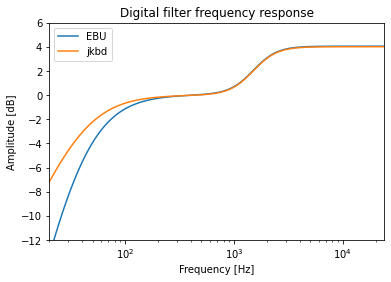

In [10]:
import matplotlib.pyplot as plt
import scipy

target_sos = np.vstack( (np.array([stage1]), np.array([stage2])) )
w, h = scipy.signal.sosfreqz(target_sos, worN=2**20, fs=samplerate)

calculated_sos = np.vstack(
    (np.array(hf_boost_shelv(K1, V_0)),
     np.array(highpass(K2, Q)))
)
w2, h2 = scipy.signal.sosfreqz(calculated_sos, worN=2**20, fs=samplerate)

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w, 20 * np.log10(abs(h)), label='EBU')
ax1.plot(w2, 20 * np.log10(abs(h2)), label='jkbd')

ax1.set_xlabel('Frequency [Hz]')
ax1.set_xscale('log')
ax1.set_ylabel('Amplitude [dB]')

plt.xlim(20, samplerate/2.0)
plt.ylim(-12, 6)
plt.legend()
plt.show()

Is there something wrong with highpass filter?

Looks like the optimisation of the second filter is weak. The result depends heavily on the initial guess.

## Second try

In [11]:
from scipy.optimize import fsolve

def solve_stage2(samplerate):
    """Minimize the difference between target biquad and calculated biquad."""
    def helper(z):
        K = z[0]
        Q = z[1]
        sos = highpass(K, Q)
        result = stage2[4:] - sos[4:]
        return result
    
    guess = np.array([0.002, 0.25], dtype=np.float64)
    result = fsolve(helper, guess)
    return result

In [12]:
result = solve_stage2(samplerate)
print(result)

K2, Q = result
print(f'freq = {cutoff_freq(K2, samplerate)} Hz')
print(f'Q = {Q}')

[0.00249597 0.50032704]
freq = 38.135470876002174 Hz
Q = 0.5003270373223665


Frequency response, again:

/tmp/ipykernel_26780/931706705.py:13: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w, 20 * np.log10(abs(h)), label='EBU')
/tmp/ipykernel_26780/931706705.py:14: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w2, 20 * np.log10(abs(h2)), label='jkbd')


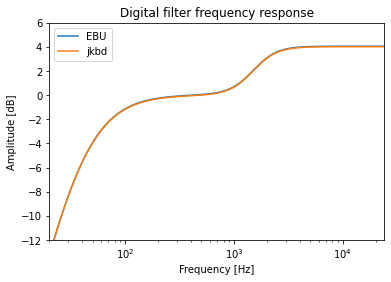

In [13]:
target_sos = np.vstack( (np.array([stage1]), np.array([stage2])) )
w, h = scipy.signal.sosfreqz(target_sos, worN=2**20, fs=samplerate)

calculated_sos = np.vstack(
    (np.array(hf_boost_shelv(K1, V_0)),
     np.array(highpass(K2, Q)))
)
w2, h2 = scipy.signal.sosfreqz(calculated_sos, worN=2**20, fs=samplerate)

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w, 20 * np.log10(abs(h)), label='EBU')
ax1.plot(w2, 20 * np.log10(abs(h2)), label='jkbd')

ax1.set_xlabel('Frequency [Hz]')
ax1.set_xscale('log')
ax1.set_ylabel('Amplitude [dB]')

plt.xlim(20, samplerate/2.0)
plt.ylim(-12, 6)
plt.legend()
plt.show()

What is the maximum difference beween the spectra?

In [14]:
diffs = np.abs(20 * np.log10(abs(h)) - 20 * np.log10(abs(h2)))
m = np.max(diffs[np.logical_not(np.isnan(diffs))])
print(f'{m} dB')

0.04334313168283899 dB


/tmp/ipykernel_26780/3750599922.py:1: RuntimeWarning: divide by zero encountered in log10
  diffs = np.abs(20 * np.log10(abs(h)) - 20 * np.log10(abs(h2)))
/tmp/ipykernel_26780/3750599922.py:1: RuntimeWarning: invalid value encountered in subtract
  diffs = np.abs(20 * np.log10(abs(h)) - 20 * np.log10(abs(h2)))


## Is it correct for other samplerates?

/tmp/ipykernel_26780/1373206645.py:23: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w, 20 * np.log10(abs(h)))


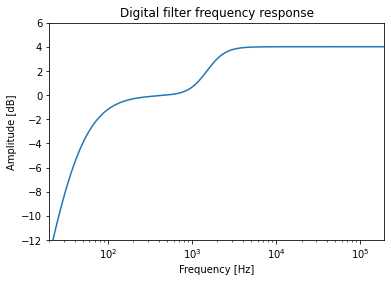

In [15]:
samplerate = 48000*8

def decibel2factor(decibel):
    return np.power(10, (decibel/20.0))

def freq2k(freq, samplerate):
    return np.tan(np.pi * freq / samplerate)

K1 = freq2k(1681.7632251028442, samplerate)
V_0 = decibel2factor(3.9997778685513232)
K2 = freq2k(38.135470876002174, samplerate)
Q = 0.5003270373223665
 
sos = np.vstack(
    (np.array(hf_boost_shelv(K1, V_0)),
     np.array(highpass(K2, Q)))
)
w, h = scipy.signal.sosfreqz(sos, worN=2**20, fs=samplerate)

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w, 20 * np.log10(abs(h)))

ax1.set_xlabel('Frequency [Hz]')
ax1.set_xscale('log')
ax1.set_ylabel('Amplitude [dB]')

plt.xlim(20, samplerate/2.0)
plt.ylim(-12, 6)
plt.show()

Looks okay.